In [1]:
import numpy as np
import matplotlib.pyplot as plt
import string
from hanziconv import HanziConv

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model, to_categorical
from keras.models import Model
from keras.layers import Input, Dense, LSTM
from keras.layers import Embedding

from IPython.display import Image

Using TensorFlow backend.


In [2]:
PATH = "D:/Program/dataset/lyrics/jay/"
ly = "JayLyrics.txt"
ly_tra = 'JayLyrics_traditional.txt'

with open(PATH+ly, "r", encoding = "utf-8") as f:
    tra = HanziConv.toTraditional(f.read())
    of = open(PATH+ly_tra, 'w', encoding="utf-8")
    of.write(tra)

In [3]:
class Param():
    batch_size = 32
    n_epoch = 50
    seq_length = 20
    metadata = 'metadata.tsv'
    n_step = 3
    n_batches_per_epoch = 500
    lyrics_long = 360

    
    remove_word = ['!', '(', ')', '*', '+', ',', '-', '.',
                   '...', '......', '............', '/','<',
                   '>', '?','[', '\\', ']', '`','~', '·',
                   '…', '☆', '\u3000', '。', '〇', '《', '》',
                   '〖', '〗', 'ー', 'ㄇ', 'ㄈ', 'ㄌ', 'ㄒ', 'ㄙ','！',
                   'ㄚ', 'ㄟ', 'ㄡ','（','）','，','＜','＞','？','～']  

In [4]:
class DataGenerator():
    def __init__(self, datafiles, args):
        self.seq_length = args.seq_length
        self.batch_size = args.batch_size
        self.n_step = args.n_step
        
        self.remove_word = args.remove_word
        self.remove_word = ''.join(self.remove_word)        
        
        with open(datafiles, encoding='utf-8') as f:
            self.data = f.read()
        
        table = str.maketrans('','',self.remove_word)
        self.data = [w.translate(table) for w in self.data]
                
        # total data length
        self.total_len = len(self.data)  
        self.words = list(set(self.data))
        self.words.sort()
        print('Total length: {}'.format(self.total_len))
        
        # vocabulary
        self.vocab_size = len(self.words)  # vocabulary size
        print('Vocabulary Size:', self.vocab_size)
        
        # dictionary
        self.char2id_dict = {w: i for i, w in enumerate(self.words)}
        self.id2char_dict = {i: w for i, w in enumerate(self.words)}
        
        # pointer position to generate current batch
        self._pointer = 0
        # save metadata file
        self.save_metadata(args.metadata)
        
        self.max_iter = args.n_epoch * \
            (self.total_len // args.seq_length) // args.batch_size
        
    def char2id(self, c):
        return self.char2id_dict[c]
    
    def id2char(self, id):
        return self.id2char_dict[id]
    
    def save_metadata(self, file):
        with open(file, 'w', encoding="utf-8") as f:
            f.write('id\tchar\n')
            for i in range(self.vocab_size):
                c = self.id2char(i)
                f.write('{}\t{}\n'.format(i, c))
                
#     def create_tokenizer(self):
#         tokenizer = Tokenizer()
#         tokenizer.fit_on_texts(self.seg_list)
#         return tokenizer
    
    def next_batch(self):
        x_batches = []
        y_batches = []
        for i in range(self.batch_size):
            if self._pointer + self.seq_length + 1 >= self.total_len:
                self._pointer = 0

            bx = self.data[self._pointer: self._pointer + self.seq_length]
#             by = self.seg_list[self._pointer +
#                            1: self._pointer + self.seq_length + 1]
            by = self.data[self._pointer + self.seq_length]

            # update pointer position
            self._pointer += 1

            # convert to ids
            bx = [self.char2id(c) for c in bx]
            by = [self.char2id(by)]

            by = to_categorical(by, num_classes=self.vocab_size)[0]

            x_batches.append(bx)
            y_batches.append(by)
        
        return x_batches, y_batches
    
    
    def data_generator(self):
        while 1:
        # loop over photo identifiers in the dataset

            for i in range(0, self.max_iter, self.n_step):
                XSeq, y = list(), list()
                for j in range(i, min(self.max_iter, i+self.n_step)):

                    # generate input-output pairs
                    in_seq, out_word = self.next_batch()

                    for k in range(len(in_seq)):
                        XSeq.append(in_seq[k])
                        y.append(out_word[k])
                # yield this batch of samples to the model
                yield [np.array(XSeq), np.array(y)]

In [5]:
def define_model(args, data):

    # embedding
    inputs = Input(shape=(args.seq_length,))
    emb2 = Embedding(data.vocab_size, 50, mask_zero=True)(inputs)
    emb3 = LSTM(256)(emb2)

    # language model (decoder)
#     lm2 = LSTM(256)(emb3)
    lm3 = Dense(500, activation='relu')(emb3)
    outputs = Dense(data.vocab_size, activation='softmax')(lm3)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    plot_model(model, show_shapes=True, to_file='plot.png')

    return model

In [6]:
args = Param()
data = DataGenerator(PATH+ly_tra, args)

Total length: 65697
Vocabulary Size: 2445


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 20, 50)            122250    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               314368    
_________________________________________________________________
dense_1 (Dense)              (None, 500)               128500    
_________________________________________________________________
dense_2 (Dense)              (None, 2445)              1224945   
Total params: 1,790,063
Trainable params: 1,790,063
Non-trainable params: 0
_________________________________________________________________
None


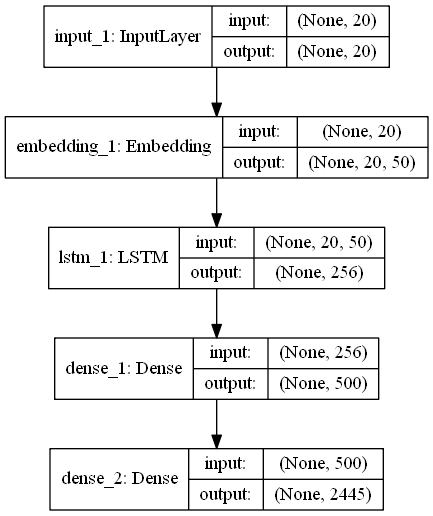

In [7]:
model = define_model(args, data)
Image('plot.png')

In [8]:
model.fit_generator(data.data_generator(), steps_per_epoch=args.n_batches_per_epoch, 
                    epochs=args.n_epoch, verbose=2)

Epoch 1/50
 - 51s - loss: 6.2620 - acc: 0.0884
Epoch 2/50
 - 60s - loss: 5.9741 - acc: 0.0916
Epoch 3/50
 - 57s - loss: 5.7284 - acc: 0.1158
Epoch 4/50
 - 48s - loss: 5.5745 - acc: 0.1189
Epoch 5/50
 - 49s - loss: 5.3228 - acc: 0.1229
Epoch 6/50
 - 49s - loss: 5.1685 - acc: 0.1354
Epoch 7/50
 - 49s - loss: 5.0587 - acc: 0.1487
Epoch 8/50
 - 49s - loss: 4.8019 - acc: 0.1579
Epoch 9/50
 - 49s - loss: 4.5769 - acc: 0.1736
Epoch 10/50
 - 48s - loss: 4.4478 - acc: 0.1925
Epoch 11/50
 - 49s - loss: 4.4018 - acc: 0.1969
Epoch 12/50
 - 49s - loss: 4.0576 - acc: 0.2288
Epoch 13/50
 - 48s - loss: 3.8752 - acc: 0.2490
Epoch 14/50
 - 48s - loss: 3.7449 - acc: 0.2699
Epoch 15/50
 - 49s - loss: 3.6195 - acc: 0.2866
Epoch 16/50
 - 48s - loss: 3.2604 - acc: 0.3368
Epoch 17/50
 - 48s - loss: 3.0593 - acc: 0.3654
Epoch 18/50
 - 48s - loss: 3.0409 - acc: 0.3741
Epoch 19/50
 - 48s - loss: 2.8950 - acc: 0.3993
Epoch 20/50
 - 48s - loss: 2.7094 - acc: 0.4266
Epoch 21/50
 - 48s - loss: 2.6119 - acc: 0.4462
E

In [58]:
model.save('D:/Program/train_model/lyrics_generator/lyrics2.h5')

In [59]:
# generate a description for an image
def generate_desc(model, args, data, in_text):
    # seed the generation process

    generated = ''
    generated += in_text
    l = len(in_text)

    # iterate over the whole length of the sequence
    for i in range(args.lyrics_long):
        # integer encode input sequence

        in_seq = [data.char2id(c) for c in in_text]

        # pad input
        sequence = pad_sequences([in_seq], maxlen=data.seq_length, padding='post')
        
        print(sequence)
        
        # predict next word
        yhat = model.predict(sequence, verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = data.id2char(yhat)

        # append as input for generating the next word        
        generated += word
        
        if i < data.seq_length-l:
            in_text+=word
        
        else:
            in_text = in_text[1:]+word

    return generated

In [62]:
in_text = '你要離開我知道 今天昨天 一起來玩 半獸人'

gen = generate_desc(model, args, data,in_text)
print(gen)

[[1968 2292 2244  844 1541 2155    2  101  524 1029  524    2   56 2069
   142 1421    2  291 1416   97]]
[[2292 2244  844 1541 2155    2  101  524 1029  524    2   56 2069  142
  1421    2  291 1416   97    2]]
[[2244  844 1541 2155    2  101  524 1029  524    2   56 2069  142 1421
     2  291 1416   97    2    2]]
[[ 844 1541 2155    2  101  524 1029  524    2   56 2069  142 1421    2
   291 1416   97    2    2 1460]]
[[1541 2155    2  101  524 1029  524    2   56 2069  142 1421    2  291
  1416   97    2    2 1460 1759]]
[[2155    2  101  524 1029  524    2   56 2069  142 1421    2  291 1416
    97    2    2 1460 1759 1974]]
[[   2  101  524 1029  524    2   56 2069  142 1421    2  291 1416   97
     2    2 1460 1759 1974  862]]
[[ 101  524 1029  524    2   56 2069  142 1421    2  291 1416   97    2
     2 1460 1759 1974  862  764]]
[[ 524 1029  524    2   56 2069  142 1421    2  291 1416   97    2    2
  1460 1759 1974  862  764 1145]]
[[1029  524    2   56 2069  142 1421    2  291

[[   1 1637  533  461  887  804    2    2    2  844 2079 1941 1810 1973
  1361    1  844 1328 1280  305]]
[[1637  533  461  887  804    2    2    2  844 2079 1941 1810 1973 1361
     1  844 1328 1280  305  247]]
[[ 533  461  887  804    2    2    2  844 2079 1941 1810 1973 1361    1
   844 1328 1280  305  247    2]]
[[ 461  887  804    2    2    2  844 2079 1941 1810 1973 1361    1  844
  1328 1280  305  247    2    2]]
[[ 887  804    2    2    2  844 2079 1941 1810 1973 1361    1  844 1328
  1280  305  247    2    2    2]]
[[ 804    2    2    2  844 2079 1941 1810 1973 1361    1  844 1328 1280
   305  247    2    2    2  475]]
[[   2    2    2  844 2079 1941 1810 1973 1361    1  844 1328 1280  305
   247    2    2    2  475 2361]]
[[   2    2  844 2079 1941 1810 1973 1361    1  844 1328 1280  305  247
     2    2    2  475 2361   56]]
[[   2  844 2079 1941 1810 1973 1361    1  844 1328 1280  305  247    2
     2    2  475 2361   56  519]]
[[ 844 2079 1941 1810 1973 1361    1  844 1328

[[   2    2  138  632  749 1759  844 1495    1 1637  533  461  887  804
     2    2    2  844 2079 1941]]
[[   2  138  632  749 1759  844 1495    1 1637  533  461  887  804    2
     2    2  844 2079 1941 1810]]
[[ 138  632  749 1759  844 1495    1 1637  533  461  887  804    2    2
     2  844 2079 1941 1810 1973]]
[[ 632  749 1759  844 1495    1 1637  533  461  887  804    2    2    2
   844 2079 1941 1810 1973 1361]]
[[ 749 1759  844 1495    1 1637  533  461  887  804    2    2    2  844
  2079 1941 1810 1973 1361    1]]
[[1759  844 1495    1 1637  533  461  887  804    2    2    2  844 2079
  1941 1810 1973 1361    1  844]]
[[ 844 1495    1 1637  533  461  887  804    2    2    2  844 2079 1941
  1810 1973 1361    1  844 1328]]
[[1495    1 1637  533  461  887  804    2    2    2  844 2079 1941 1810
  1973 1361    1  844 1328 1280]]
[[   1 1637  533  461  887  804    2    2    2  844 2079 1941 1810 1973
  1361    1  844 1328 1280  305]]
[[1637  533  461  887  804    2    2    2  844

[[   1  461  844  462 1508 2138    2    2    2  138  632  749 1759  844
  1495    1 1637  533  461  887]]
[[ 461  844  462 1508 2138    2    2    2  138  632  749 1759  844 1495
     1 1637  533  461  887  804]]
[[ 844  462 1508 2138    2    2    2  138  632  749 1759  844 1495    1
  1637  533  461  887  804    2]]
[[ 462 1508 2138    2    2    2  138  632  749 1759  844 1495    1 1637
   533  461  887  804    2    2]]
[[1508 2138    2    2    2  138  632  749 1759  844 1495    1 1637  533
   461  887  804    2    2    2]]
[[2138    2    2    2  138  632  749 1759  844 1495    1 1637  533  461
   887  804    2    2    2  844]]
[[   2    2    2  138  632  749 1759  844 1495    1 1637  533  461  887
   804    2    2    2  844 2079]]
[[   2    2  138  632  749 1759  844 1495    1 1637  533  461  887  804
     2    2    2  844 2079 1941]]
[[   2  138  632  749 1759  844 1495    1 1637  533  461  887  804    2
     2    2  844 2079 1941 1810]]
[[ 138  632  749 1759  844 1495    1 1637  533

[[ 475 2361   56  519    1  461  844  462 1508 2138    2    2    2  138
   632  749 1759  844 1495    1]]
[[2361   56  519    1  461  844  462 1508 2138    2    2    2  138  632
   749 1759  844 1495    1 1637]]
[[  56  519    1  461  844  462 1508 2138    2    2    2  138  632  749
  1759  844 1495    1 1637  533]]
[[ 519    1  461  844  462 1508 2138    2    2    2  138  632  749 1759
   844 1495    1 1637  533  461]]
[[   1  461  844  462 1508 2138    2    2    2  138  632  749 1759  844
  1495    1 1637  533  461  887]]
[[ 461  844  462 1508 2138    2    2    2  138  632  749 1759  844 1495
     1 1637  533  461  887  804]]
[[ 844  462 1508 2138    2    2    2  138  632  749 1759  844 1495    1
  1637  533  461  887  804    2]]
[[ 462 1508 2138    2    2    2  138  632  749 1759  844 1495    1 1637
   533  461  887  804    2    2]]
[[1508 2138    2    2    2  138  632  749 1759  844 1495    1 1637  533
   461  887  804    2    2    2]]
[[2138    2    2    2  138  632  749 1759  844